In [2]:
from keras.layers import Input, Lambda, Dense, Flatten, Dropout
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [3]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/drive/MyDrive/Covid-Detection/Train'
valid_path = '/content/drive/MyDrive/Covid-Detection/Val'


In [4]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58900480/58889256 [==============================] - 1s 0us/step


In [5]:
# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

In [6]:
# useful for getting number of classes
folders = glob('/content/drive/MyDrive/Covid-Detection/Train')

In [7]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)
x = Dense(1000, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(100, activation='relu')(x)
x = Dropout(0.5)(x)
prediction = Dense(len(folders), activation='sigmoid')(x)

In [8]:
# create a model object
model = Model(vgg.input, prediction)

In [9]:
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [10]:
# tell the model what cost and optimization method to use
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [13]:
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Covid-Detection/Train',
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Covid-Detection/Val',
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'binary')


Found 224 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


In [14]:
# implementing early stopping and model check point 

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

es = EarlyStopping(monitor= "val_accuracy" , min_delta= 0.01, patience= 3, verbose=1)
mc = ModelCheckpoint(filepath="bestmodel.h5", monitor="val_accuracy", verbose=1, save_best_only= True)

In [15]:
# fit the model
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=8,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set),
)
# callbacks=[es,mc]
'''r=model.fit_generator(training_set,
                         steps_per_epoch = 7,
                         epochs = 5,
                         validation_data = test_set,
                         validation_steps = 500)'''

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/8
4/4 [==============================] - 200s 33s/step - loss: 1.1238 - accuracy: 0.5349 - val_loss: 0.1505 - val_accuracy: 0.9667
Epoch 2/8
4/4 [==============================] - 12s 3s/step - loss: 0.5559 - accuracy: 0.8336 - val_loss: 0.3316 - val_accuracy: 0.9333
Epoch 3/8
4/4 [==============================] - 12s 3s/step - loss: 0.1938 - accuracy: 0.9282 - val_loss: 0.2168 - val_accuracy: 0.9667
Epoch 4/8
4/4 [==============================] - 12s 3s/step - loss: 0.1786 - accuracy: 0.9321 - val_loss: 0.2630 - val_accuracy: 0.9667
Epoch 5/8
4/4 [==============================] - 11s 3s/step - loss: 0.1418 - accuracy: 0.9623 - val_loss: 0.3094 - val_accuracy: 0.9667
Epoch 6/8
4/4 [==============================] - 11s 3s/step - loss: 0.2389 - accuracy: 0.9561 - val_loss: 0.3740 - val_accuracy: 0.9667
Epoch 7/8
4/4 [==============================] - 11s 3s/step - loss: 0.2127 - accuracy: 0.9644 - val_loss: 0.3778 - val_accuracy: 0.9333
Epoch 8/8
4/4 [========================

'r=model.fit_generator(training_set,\n                         steps_per_epoch = 7,\n                         epochs = 5,\n                         validation_data = test_set,\n                         validation_steps = 500)'

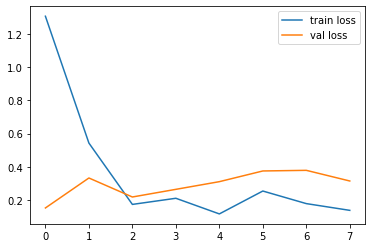

<Figure size 432x288 with 0 Axes>

In [16]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')


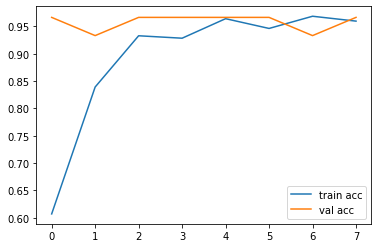

<Figure size 432x288 with 0 Axes>

In [17]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [18]:
import tensorflow as tf

from keras.models import load_model

model.save('transfer_learning_model.h5')

In [27]:
model.evaluate_generator(training_set)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1948: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.040722157806158066, 0.9955357313156128]

In [28]:
model.evaluate_generator(test_set)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1948: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.3698572516441345, 0.949999988079071]

In [36]:
# checking out the accurscy of our model 

acc = model.evaluate_generator(generator= test_set)[1] 

print(f"The accuracy of your model is = {acc} %")

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1948: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


The accuracy of your model is = 0.949999988079071 %


Grad Cam Visualisation

In [19]:
# this function is udes to generate the heat map of aan image
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [20]:
import matplotlib.cm as cm
import keras
from IPython.display import Image, display

In [21]:
class_type = {0:'Covid',  1 : 'Normal'}

In [22]:
def save_and_display_gradcam(img_path , heatmap, cam_path="/content/drive/MyDrive/Covid-Detection/Val/Covid/16654_1_1.png", alpha=0.6):
    """
    img input shoud not be expanded 
    """

    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

In [23]:
from keras.preprocessing import image

def get_img_array(img_path):
  """
  Input : Takes in image path as input 
  Output : Gives out Pre-Processed image
  """
  path = img_path
  img = image.load_img(path, target_size=(224,224,3))
  img = image.img_to_array(img)
  img = np.expand_dims(img , axis= 0 )
  
  return img

In [24]:
def image_prediction_and_visualization(path,last_conv_layer_name = "block5_conv3", model = model):
  """
  input:  is the image path, name of last convolution layer , model name
  output : returs the predictions and the area that is effected
  """
  
  img_array = get_img_array(path)

  heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

  plt.title("the heat map of the image is ")
  plt.imshow(heatmap)
  plt.show()
  print()
  img = get_img_array(path)

  res = class_type[np.argmax(model.predict(img))]
  print(f"The given X-Ray image is of type = {res}")
  print()
  print("image with heatmap representing region on interest")

  # function call
  save_and_display_gradcam(path, heatmap)

  print()
  print("the original input image")
  print()

  a = plt.imread(path)
  plt.imshow(a, cmap = "gray")
  plt.title("Original image")
  plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


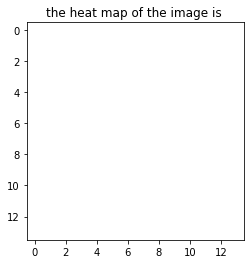


The given X-Ray image is of type = Covid

image with heatmap representing region on interest


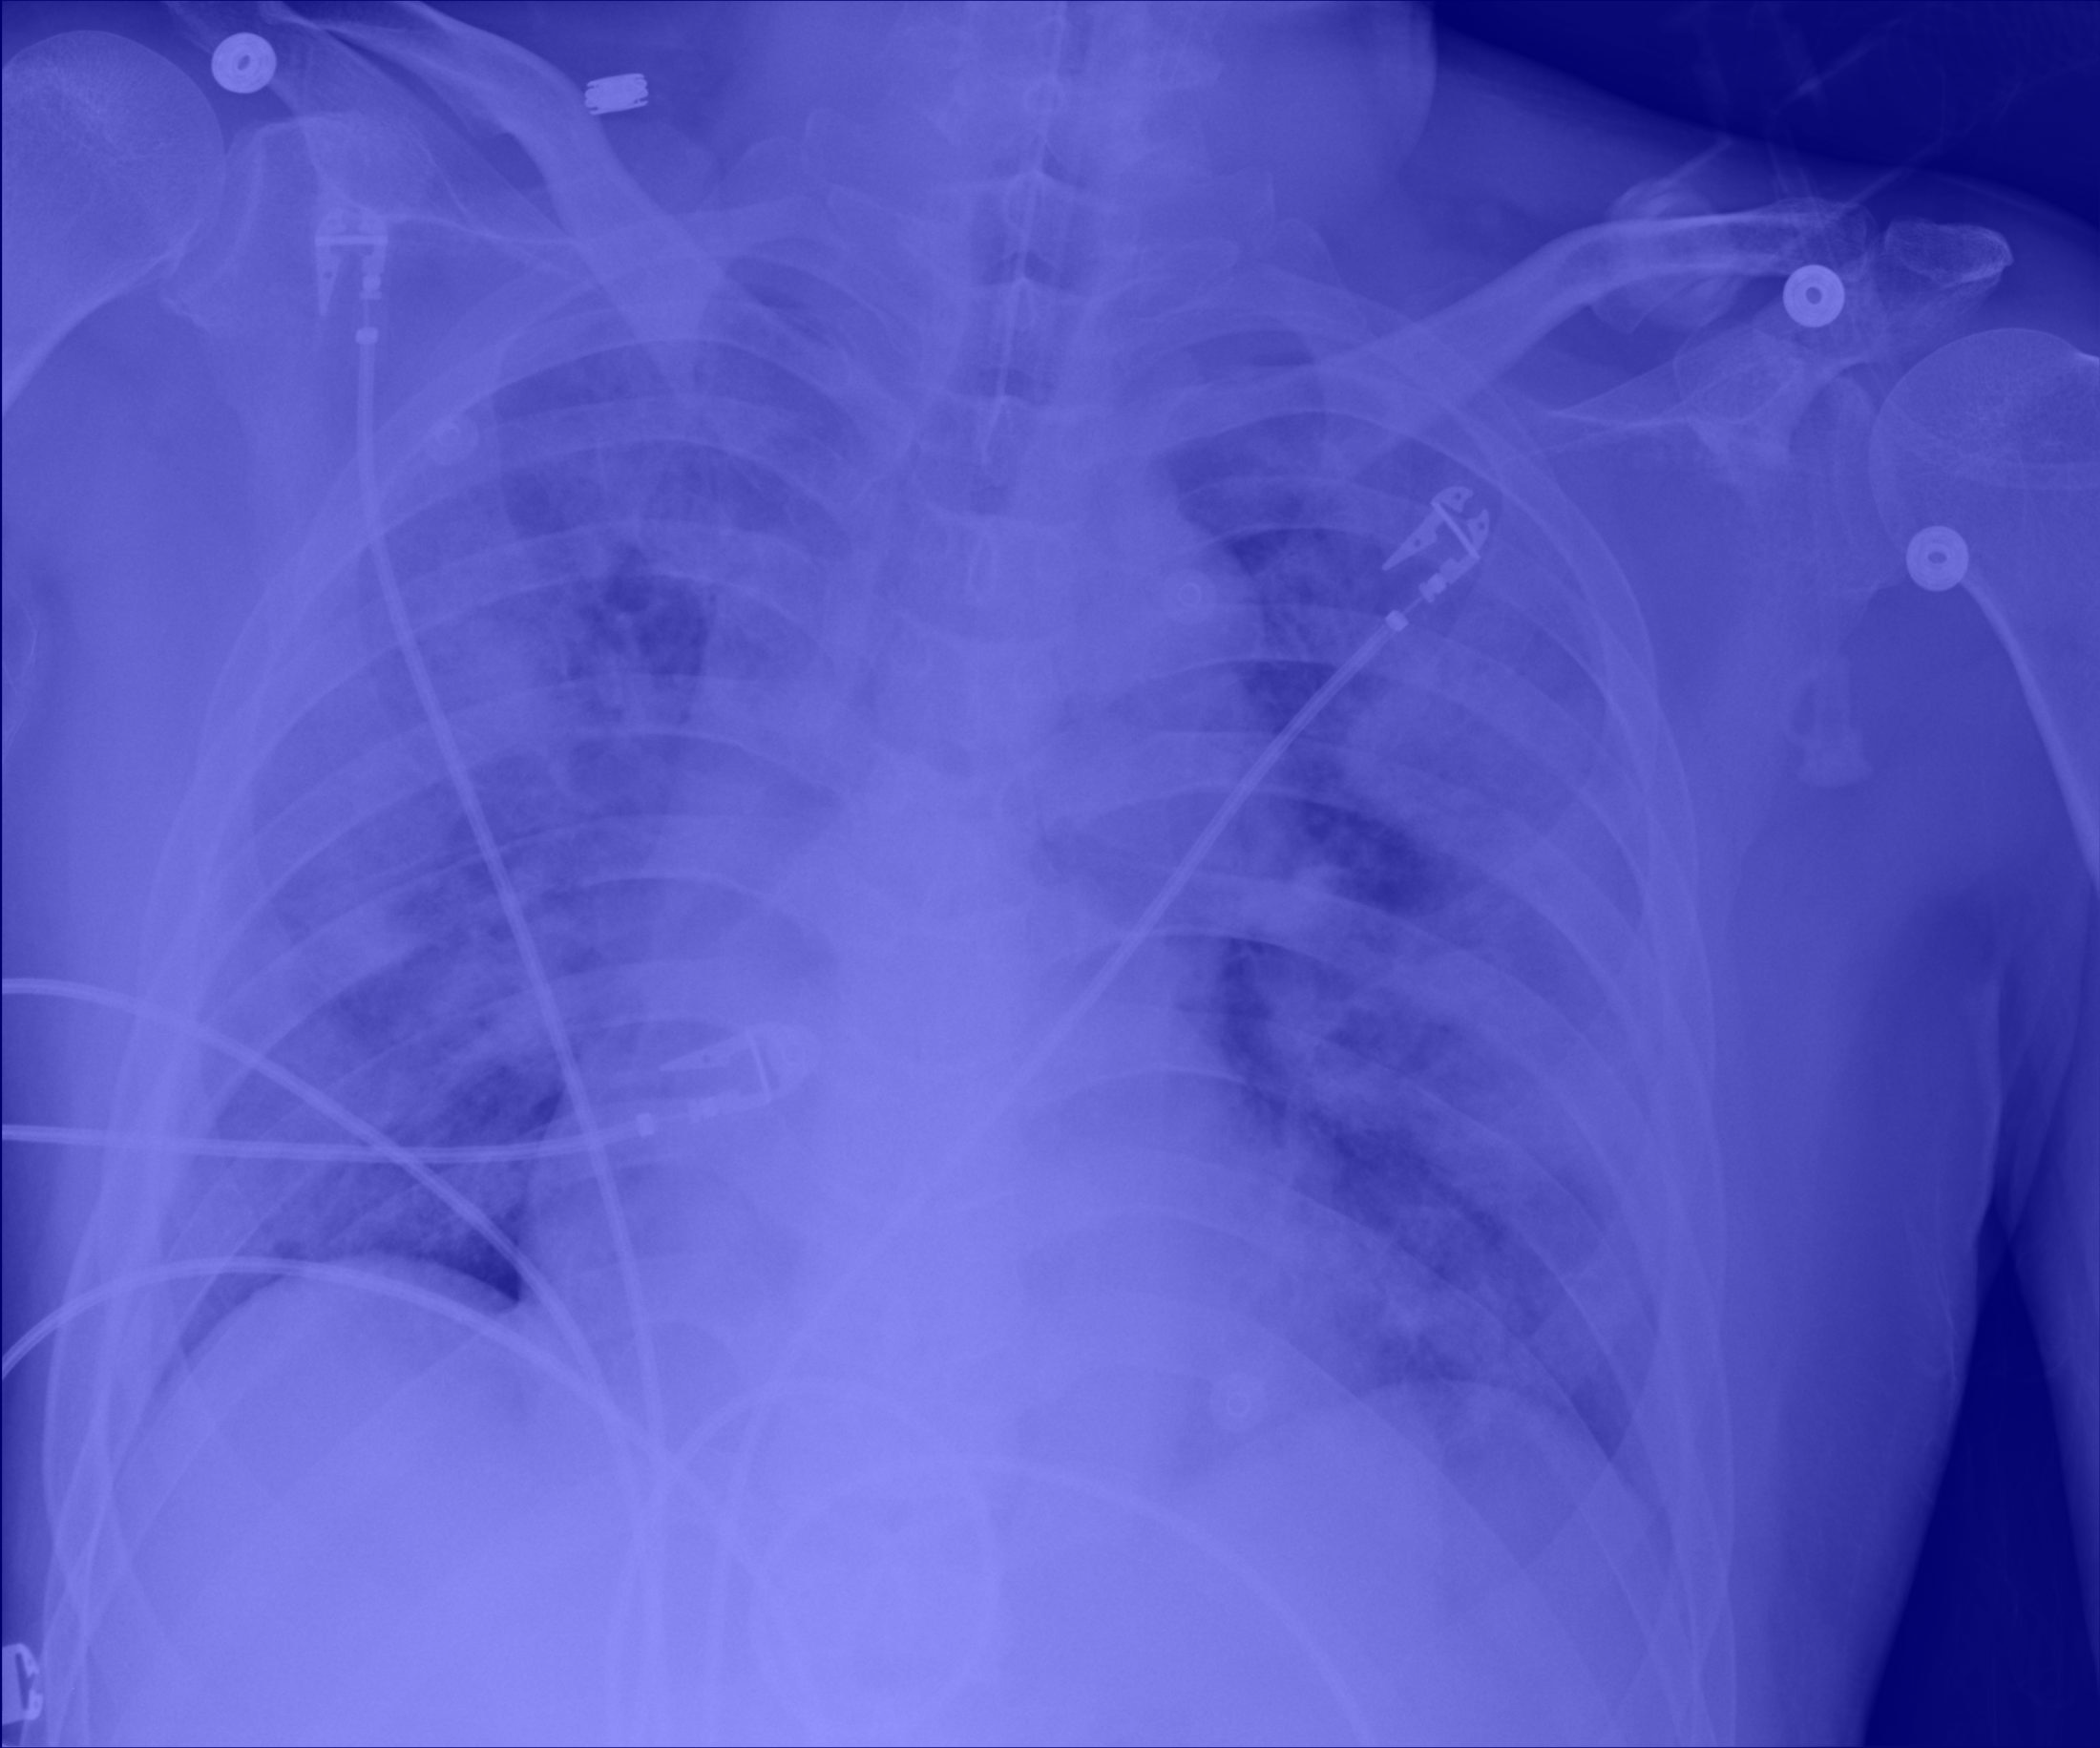


the original input image



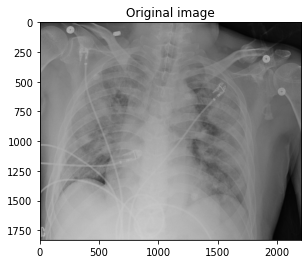

In [25]:
#predictions
# provide the path of any image from google or any other scource 
# the path is already defigned above , but you can also provide the path here to avoid scrolling up 

# for covid image :  path:- provide any image from google or provide image from all image folder
path = "/content/drive/MyDrive/Covid-Detection/Val/Covid/16654_4_1.jpg"

image_prediction_and_visualization(path)

/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


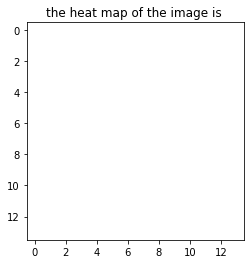


The given X-Ray image is of type = Covid

image with heatmap representing region on interest


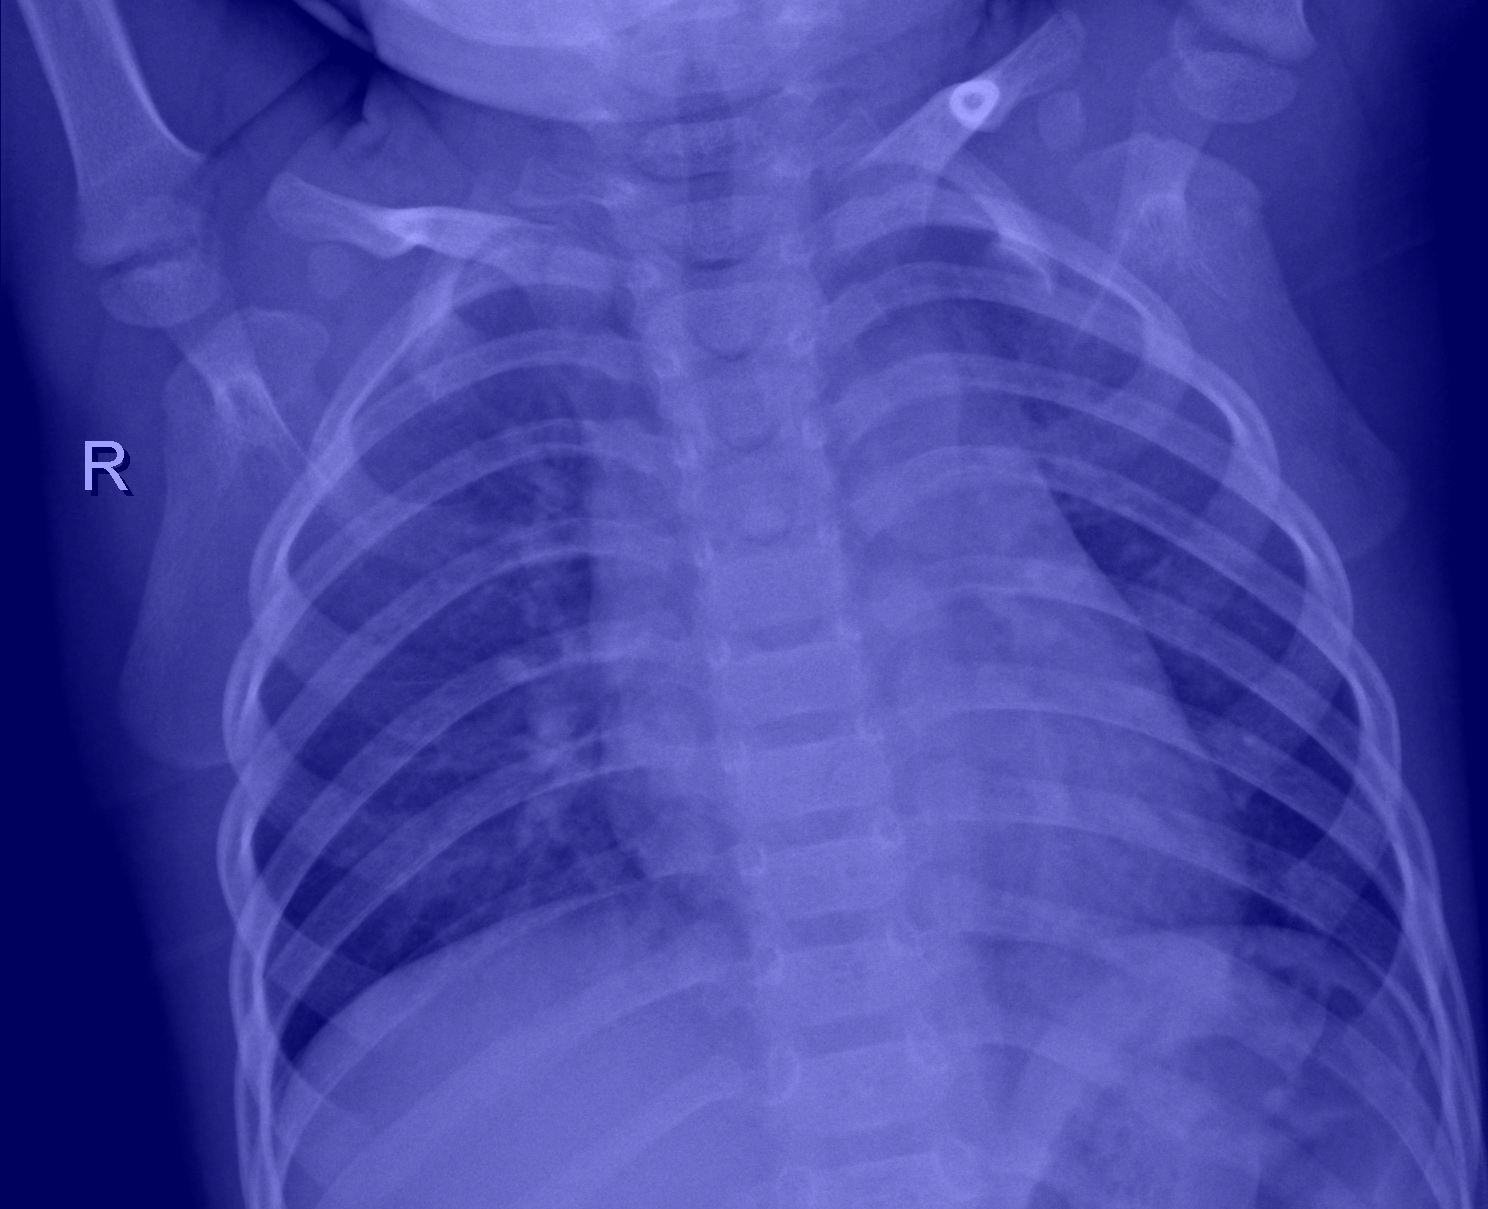


the original input image



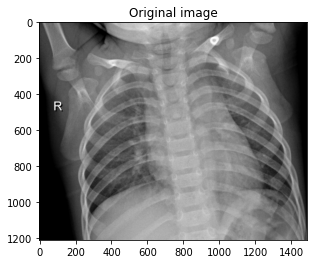

In [26]:
# for normal image :  path:- provide any image from google or provide image from all image folder
path = "/content/drive/MyDrive/Covid-Detection/Train/Normal/IM-0156-0001.jpeg"

image_prediction_and_visualization(path)

# for a healthey chest x-Ray heap map will be white thus the x-ray will look blue